<a href="https://colab.research.google.com/github/jpatrickweller/Data_Challenges/blob/main/GARCH_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [194]:
# uh oh, missing arch. Let's install.
!pip install arch

In [195]:
# Bring in the usual suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from random import gauss
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

In [208]:
# Create dataset
# Building a Garch(2,2) model
# Et = N(0,1)

def make_garch_process(n):

    # Define parameters for Garch model
    alpha_1 = 0.1
    alpha_2 = 0.2
    beta_1 = 0.3
    beta_2 = 0.4
    omega = 0.5

    # Initializing starting time points (t-1 and t-2)
    garch_ts = [gauss(0,1), gauss(0,1)]
    vols = [1, 1]

    for _ in range(n):
        new_vol = np.sqrt(alpha_1*garch_ts[-1]**2 + alpha_2*garch_ts[-2]**2 + 
                        beta_1*vols[-1]**2 + beta_2*vols[-2]**2 + omega)
        new_val = new_vol * gauss(0,1)

        vols.append(new_vol)
        garch_ts.append(new_val)
        
    return garch_ts, vols

# now gimmie!
n = 2000
garch_ts, vols = make_garch_process(n)

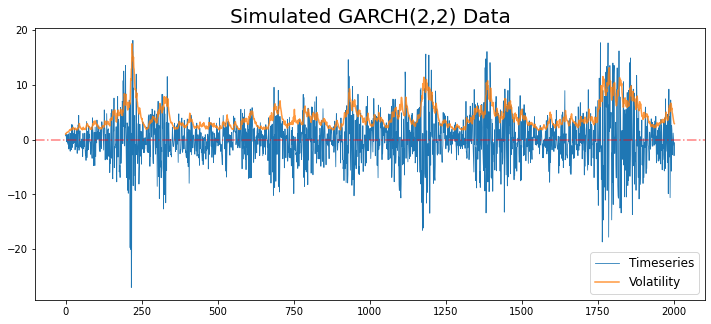

In [209]:
# Plot that garch!
def plot_garch(observations, volatilities):

    plt.figure(figsize=(12,5))
    plt.title('Simulated GARCH(2,2) Data', fontsize=20)
    plt.plot(observations, linewidth=.8, label='Timeseries')
    plt.plot(volatilities, label='Volatility', alpha=.8)
    plt.legend(loc='best', fontsize=12)
    plt.axhline(y=0, linestyle='-.', color='r', alpha=.5)
    plt.show()

plot_garch(garch_ts, vols)


# Fit the GARCH model

I'mma try to recover the parameters I defined above.

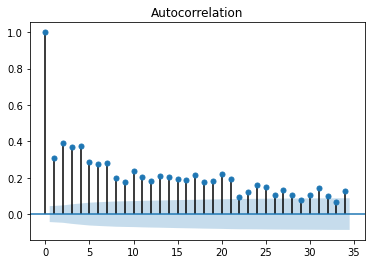

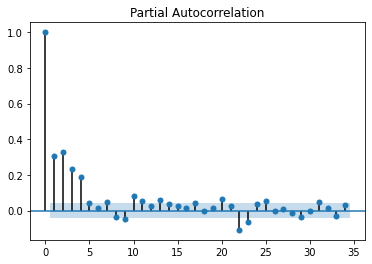

In [210]:
# Find the order of the GARCH model that we're going to make

# squaring bc under a garch model, the timeseries is a function of the sqrt
# of the alpha and beta parameters.
s = np.array(garch_ts)**2

# AR components?
plot_acf(s)
plt.show()

# MA components
plot_pacf(s) 
plt.show()

In [211]:
# Well, there's a good argument to start with a GARCH(2,4) model...
# Let's see what happens with this order of model

def ttsplit(observations):
    test_size = int(len(observations)*.1)
    train_data = observations[:-test_size]
    test_data = observations[-test_size:]
    return train_data, test_data

def fit_garch_model(observations, p, q):

    # Load the model
    model = arch_model(observations, p=p, q=q)

    # Train the model
    model_fit = model.fit(disp='off')

    # Assess the model
    # print(model_fit.summary()) 

    return model_fit

# Set the model params from above
train_data, test_data = ttsplit(garch_ts)
p,q = 2,2
model_fit = fit_garch_model(train_data, p, q)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4784.66
Distribution:                  Normal   AIC:                           9581.31
Method:            Maximum Likelihood   BIC:                           9614.29
                                        No. Observations:                 1802
Date:                Wed, Mar 03 2021   Df Residuals:                     1801
Time:                        06:06:05   Df Model:                            1
                                Mean Model                               
=========================================================================
                  coef    std err          t      P>|t|  95.0% Conf. Int.
-------------------------------------------------------------------------
mu         -8.7440e-03  6.372e-02     -0.137      0.891 [ -0.134,  0.116]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.4158      0.117      3.552  3.829e-04   [  0.186,  0.645]
alpha[1]       0.0865  2.761e-02      3.134  1.724e-03 [3.241e-02,  0.141]
alpha[2]       0.1675  4.738e-02      3.535  4.081e-04 [7.461e-02,  0.260]
beta[1]        0.5636      0.243      2.315  2.060e-02 [8.648e-02,  1.041]
beta[2]        0.1708      0.198      0.861      0.389   [ -0.218,  0.560]
==========================================================================

Covariance estimator: robust
"""

# Forecast

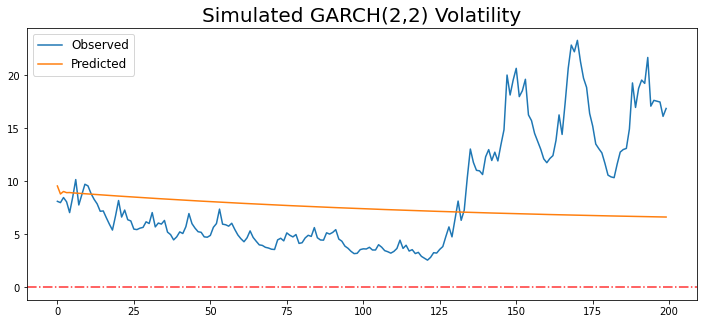

In [212]:
# First, lets just make a forecast for the whole test set. This will be worse 
# than a rolling prediction, but let's see how well it does.

# Get the std (the whole point or GARCH is to estimate the variance)
def get_pred_volatility(predictions):
    return np.sqrt(predictions.variance.values[-1,:])


def plot_garch_volatility(observed, predicted):

    plt.figure(figsize=(12,5))
    plt.title('Simulated GARCH(2,2) Volatility', fontsize=20)
    plt.plot(observed, label='Observed')
    plt.plot(predicted, label='Predicted')
    plt.legend(loc='best', fontsize=12)
    plt.axhline(y=0, linestyle='-.', color='r', alpha=.8)
    plt.show()

predictions = model_fit.forecast(horizon=len(test_data))
pred_std = get_pred_volatility(predictions)
obs_std = vols[-len(test_data):]
plot_garch_volatility(test_std, pred_std)


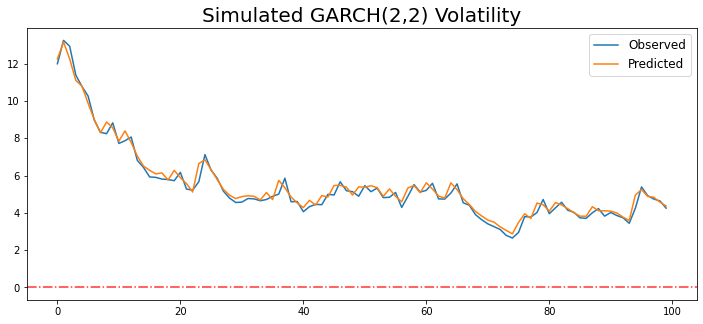

In [226]:
# Make rolling predictions

rolling_predictions = []
rolling_train_data = train_data

for test_idx in range(len(test_data)):
    
    # Add data point
    if test_idx > 0:
        rolling_train_data = np.append(rolling_train_data,test_data[test_idx-1])

    # Fit a garch model
    p, q = 2, 2
    model_fit = fit_garch_model(rolling_train_data, p, q)   

    # Forecast
    pred = model_fit.forecast(horizon=10)
    pred_std = np.sqrt(pred.variance.values[-1,:][-1])
    rolling_predictions.append(pred_std)

obs_std = vols[-len(test_data):]
plot_garch_volatility(obs_std, rolling_predictions)

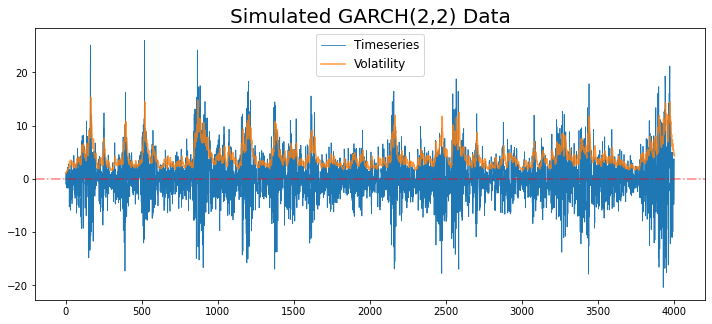

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -9699.72
Distribution:                  Normal   AIC:                           19411.4
Method:            Maximum Likelihood   BIC:                           19448.6
                                        No. Observations:                 3602
Date:                Wed, Mar 03 2021   Df Residuals:                     3601
Time:                        06:14:10   Df Model:                            1
                                 Mean Model                                
                  coef    std err          t      P>|t|    95.0% Conf. Int.
---------------------------------------------------------------------------
mu         -4.2164e-03  4.920e-02 -8.570e-02      0.932 [ -0.

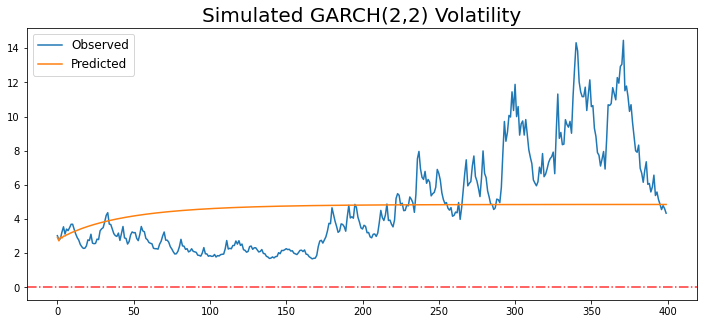

In [234]:
# Running a few examples of the whole process...

# Make a garch process
n=4000
garch_ts, vols = make_garch_process(n)

# Show me
plot_garch(garch_ts, vols)

# Train/test split
train_data, test_data = ttsplit(garch_ts)

# Fit a garch model
p, q = 2, 2
model_fit = fit_garch_model(train_data, p, q)
print(model_fit.summary())

# Make predictions
predictions = model_fit.forecast(horizon=len(test_data))

# Plot the estimate of volatility
pred_std = get_pred_volatility(predictions)
obs_std = vols[-len(test_data):]
plot_garch_volatility(obs_std, pred_std)